In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import time

palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="cmr10", font_scale=1.0)
plt.rcParams['axes.formatter.use_mathtext'] = True

In [2]:
def load_nef_values(load=True):
    if load:
        values = pd.read_pickle("data/nef_values_condensed.pkl")
    else:
        emp = pd.read_pickle("data/empirical.pkl")
        dfs = []
        for monkey in ['V', 'W']:
            for session in [0,1,2,3]:
                for block in emp.query("monkey==@monkey & session==@session")['block'].unique():
                    for trial in emp.query("monkey==@monkey & session==@session & block==@block")['trial'].unique():
                        file = f"monkey{monkey}_session{session}_block{block}_trial{trial}"
                        dfs.append(pd.read_pickle(f'data/nef_spikes/{file}_values.pkl'))
        values = pd.concat(dfs, ignore_index=True)
        values['dvs'] = values['va'] - values['vb']
        values['dva'] = values['vl'] - values['vr']
        values = values.drop(columns='block_type')
        values = values.drop(columns='before')
        values = values.drop(columns='after')
        values = values.drop(columns='acc')
        values.to_pickle("data/nef_values_condensed.pkl")
    return values

In [3]:
def load_rl_values(load=True):
    if load:
        values = pd.read_pickle("data/rl_values_condensed.pkl")
    else:
        dfs = []
        for monkey in ['V', 'W']:
            for session in [0,1,2,3]:
                for block in range(1, 25):
                    for trial in range(1, 81):
                        file = f"monkey{monkey}_session{session}_block{block}_trial{trial}"
                        try:
                            dfs.append(pd.read_pickle(f'data/emp_spikes/{file}_values.pkl'))
                        except:
                            pass
        values = pd.concat(dfs, ignore_index=True)
        values.to_pickle("data/rl_values_condensed.pkl")
    return values

In [20]:
def load_spikes(load=True, spike_type='nef'):
    filename = f"{spike_type}_spikes_dataframe"
    loadname = "nef" if spike_type=='nef' else 'emp'
    if load:
        dataframe_spikes = pd.read_pickle(f"data/{filename}.pkl")
    else:
        dfs = []
        emp = pd.read_pickle("data/empirical.pkl")
        for monkey in emp['monkey'].unique():
            for session in emp['session'].unique():
                print(monkey, session)
                for block in emp.query("monkey==@monkey & session==@session")['block'].unique():
                    for trial in emp.query("monkey==@monkey & session==@session & block==@block")['trial'].unique():
                        if spike_type=='nef':
                            spikes = np.load(f"data/{loadname}_spikes/monkey{monkey}_session{session}_block{block}_trial{trial}_spikes.npz")['vwa'].sum(axis=0)  # sum over time
                        else:
                            try:
                                spikes = np.load(f"data/{loadname}_spikes/monkey{monkey}_session{session}_block{block}_trial{trial}_spikes.npz")['spikes']
                            except:
                                print(monkey, session, block, trial)
                                continue
                        n_neurons = spikes.shape[0]
                        df = pd.DataFrame()
                        df['monkey'] = [monkey for _ in range(n_neurons)]
                        df['session'] = [session for _ in range(n_neurons)]
                        df['block'] = [block for _ in range(n_neurons)]
                        df['trial'] = [trial for _ in range(n_neurons)]
                        df['neuron'] = [n for n in range(n_neurons)]
                        df['spikes'] = [spikes[n] for n in range(n_neurons)]
                        dfs.append(df)
        dataframe_spikes = pd.concat(dfs, ignore_index=True)
        dataframe_spikes.to_pickle(f"data/{filename}.pkl")
    return dataframe_spikes

In [12]:
nef_spikes = load_spikes(load=True, spike_type='nef')

In [22]:
monkey_spikes = load_spikes(load=True, spike_type='monkey')

In [26]:
nef_values = load_nef_values()

In [27]:
rl_values = load_rl_values()

In [68]:
nef_weights = pd.read_pickle("data/nef_weight_vwa.pkl")

In [65]:
def get_top_neurons(df_weights, monkey, session, target_variable, top_n=1):
    df_filtered = df_weights[
        (df_weights['monkey'] == monkey) &
        (df_weights['session'] == session) &
        (df_weights['variable'] == target_variable)
    ]
    if df_filtered.empty:
        return []
    # Sort by weight descending and return top N neuron IDs
    top_neurons = df_filtered.sort_values('weight', ascending=False)['neuron'].head(top_n).tolist()
    return top_neurons

In [47]:
def compute_x_bins(df_values, target_variable, method='uniform', n_bins=10):
    x = df_values[target_variable].dropna()
    if method == 'uniform':
        # Equal-width bins between min and max
        bin_edges = np.linspace(x.min(), x.max(), n_bins + 1)
    elif method == 'quantile':
        # Quantile-based bin edges (equal number of samples per bin)
        bin_edges = np.unique(np.quantile(x, q=np.linspace(0, 1, n_bins + 1)))
    else:
        raise ValueError("method must be either 'uniform' or 'quantile'")
    return bin_edges

In [114]:
def plot_multi_variable_tuning(
    df_spikes, df_values,
    monkey, session, neuron,
    all_variables, target_variable,
    bin_method='uniform', n_bins=10, order=2):

    # Filter data
    merge_keys = ['monkey', 'session', 'block', 'trial']
    df_neuron = df_spikes[
        (df_spikes['monkey'] == monkey) &
        (df_spikes['session'] == session) &
        (df_spikes['neuron'] == neuron)
    ]
    df_values_filtered = df_values[
        (df_values['monkey'] == monkey) &
        (df_values['session'] == session)
    ]
    df_merged = pd.merge(df_neuron, df_values_filtered, on=merge_keys)

    if df_merged.empty:
        print(f"No data for monkey {monkey}, session {session}, neuron {neuron}")
        return

    # Set up horizontal layout
    n_vars = len(all_variables)
    fig, axes = plt.subplots(1, n_vars, figsize=(2 * n_vars, 3), sharey=True)

    if n_vars == 1:
        axes = [axes]  # Make iterable

    for idx, var in enumerate(all_variables):
        ax = axes[idx]

        if var not in df_merged.columns or df_merged[var].isna().all():
            ax.set_visible(False)
            continue

        try:
            x_bins = compute_x_bins(df_merged, var, method=bin_method, n_bins=n_bins)
        except:
            ax.set_visible(False)
            continue

        # sns.regplot(data=df_merged,x=var, y='spikes',x_bins=x_bins,order=order,ax=ax,color=palette[0])

        df_merged['bin'] = pd.cut(df_merged[var], bins=x_bins, include_lowest=True)
        df_merged['bin_center'] = df_merged['bin'].apply(lambda b: (b.left + b.right) / 2)

        sns.lineplot(data=df_merged, x='bin_center', y='spikes', ax=ax, color=palette[0])

        # bin_centers = sorted(df_merged['bin_center'].unique())
        # ax.set_xticks(bin_centers)
        # ax.set_xticklabels([f"{x:.2f}" for x in bin_centers], rotation=45)

        # Highlight target variable
        if var == target_variable:
            for spine in ax.spines.values():
                spine.set_linewidth(2)
        
        ax.set_ylabel("Spike Count" if idx == 0 else "")
        ax.set_xlabel(var)
        ax.set(xlim=(-1,1))

    fig.suptitle(
        f"Tuning Curves for Monkey {monkey}, Session {session}, Neuron {neuron}",
        fontsize=14, fontweight='bold'
    )
    plt.tight_layout()
    plt.show()

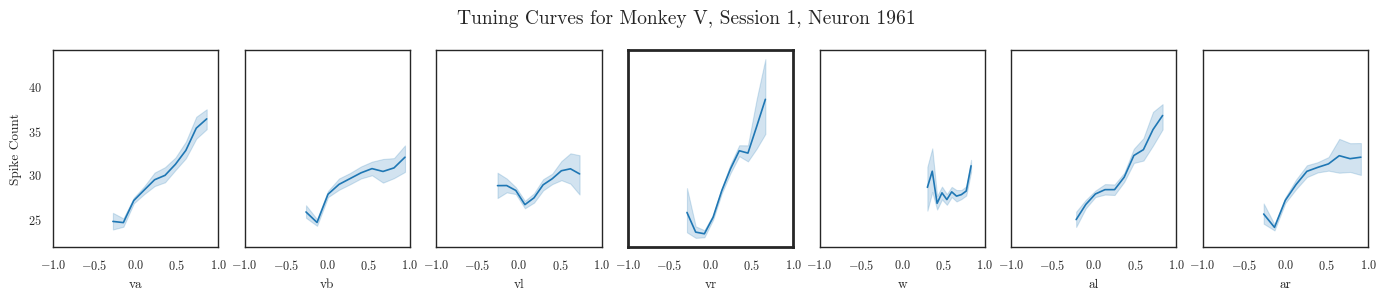

In [116]:
monkey = 'V'
session = 1
target_variable = 'vr'
all_variables = ['va', 'vb', 'vl', 'vr', 'w', 'al', 'ar']
top_n = 1
top_neurons = get_top_neurons(nef_weights, monkey=monkey, session=session, target_variable=target_variable, top_n=top_n)

plot_multi_variable_tuning(nef_spikes,nef_values,
        monkey=monkey, session=session,
        neuron=top_neurons[0],
        all_variables=all_variables,
        target_variable=target_variable,
        bin_method='uniform')